# Résolution problème Thurber

Source: [Thurber.dat](https://www.itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Thurber.dat)

$n=7,\ m=37$

In [1]:
# Modules and ENLSIP imports

using ForwardDiff, JuMP, Ipopt, BenchmarkTools

include("../src/enlsip_functions_castor2.jl")

enlsip

In [2]:
n = 7
m = 37
nb_eq = 0
nb_constraints = 2*n;

In [3]:
data = [80.574      -3.067
      84.248      -2.981
      87.264      -2.921
      87.195      -2.912
      89.076      -2.840
      89.608      -2.797
      89.868      -2.702
      90.101      -2.699
      92.405      -2.633
      95.854      -2.481
     100.696      -2.363
     101.060      -2.322
     401.672      -1.501
     390.724      -1.460
     567.534      -1.274
     635.316      -1.212
     733.054      -1.100
     759.087      -1.046
     894.206      -0.915
     990.785      -0.714
    1090.109      -0.566
    1080.914      -0.545
    1122.643      -0.400
    1178.351      -0.309
    1260.531      -0.109
    1273.514      -0.103
    1288.339       0.010
    1327.543       0.119
    1353.863       0.377
    1414.509       0.790
    1425.208       0.963
    1421.384       1.006
    1442.962       1.115
    1464.350       1.572
    1468.705       1.841
    1447.894       2.047
    1457.628       2.200]

y = data[:,1]
t = data[:,2];

In [4]:
# Résidus

function r_i(x::Vector,t::Float64,y::Float64)
    return y - (x[1] + x[2]*t + x[3]*t^2 + x[4]*t^3) / (1 + x[5]*t + x[6]*t^2 + x[7]*t^3)
end

function r(x::Vector)
    return [r_i(x,t[i],y[i]) for i=1:m]
end

resThurber = ResidualsEval(0)

function (resThurber::ResidualsEval)(x::Vector{Float64}, rx::Vector{Float64}, J::Matrix{Float64})
    
    if resThurber.ctrl == 1
        rx[:] = r(x)
    elseif resThurber.ctrl == 2
        J[:] = ForwardDiff.jacobian(r,x)
    end
    return
end

In [5]:
# Contraintes

function c(x::Vector)
    return [x[1]-1000; 1300 - x[1];
        x[2]-1000; 1500 - x[2];
        x[3]-300; 600 - x[3];
        x[4]; 100- x[4];
        x[5]; 1 - x[5];
        x[6]; 1 - x[6];
        x[7]; 1 - x[7]]
end

consThurber = ConstraintsEval(0)

function (consThurber::ConstraintsEval)(x::Vector{Float64}, cx::Vector{Float64}, A::Matrix{Float64})
    
    if consThurber.ctrl == 1
        cx[:] = c(x)
    elseif consThurber.ctrl == 2
        A[:] = ForwardDiff.jacobian(c,x)
    end
    return
end   

In [9]:
# x0 = [1300.0, 1500.0, 500.0, 75.0, 1.0, 0.4, 0.05]# 
x0 = [1000.0, 1000.0, 400.0, 40., 0.7, 0.3, 0.03] # 

e = eps(Float64)
se = sqrt(e)
enlsipThurber = enlsip(x0,resThurber,consThurber,n,m,nb_eq,nb_constraints)
@printf "f(x_jul) = %.10e\n\n" enlsipThurber.obj_value


****************************************
*                                      *
*          ENLSIP-JULIA-0.4.0          *
*                                      *
****************************************

Starting point : [1000.0, 1000.0, 400.0, 40.0, 0.7, 0.3, 0.03]

Starting point :
    1.000000e+03   1.000000e+03   4.000000e+02   4.000000e+01   7.000000e-01   3.000000e-01   3.000000e-02 

Number of equality constraints   : 0
Number of inequality constraints : 14
Constraints internal scaling     : false


Iteration steps information

iter     objective    cx_sum   reduction     ||p||   dimA  dimJ2     α     conv. speed   max weight   working set
   0  4.528125e+06  0.00e+00   2.51e+06   3.915e+02   1     6   4.01e-01    0.00e+00     1.00e-01    (3)
   1  2.019970e+06  0.00e+00   7.68e+05   2.211e+02   1     6   2.20e-01    6.67e-01     1.00e-01    (5)
   2  1.251528e+06  0.00e+00   1.07e+06   1.950e+02   1     6   6.61e-01    7.86e-01     1.00e-01    (13)
   3  1.796351e+05  0.00e+

Model:         Rational Class (cubic/cubic)
               7 Parameters (b1 to b7)

               y = (b1 + b2*x + b3*x**2 + b4*x**3) / 
                   (1 + b5*x + b6*x**2 + b7*x**3)  +  e


          Starting Values                  Certified Values

        Start 1     Start 2           Parameter     Standard Deviation
        
  b1 =   1000        1300          1.2881396800E+03  4.6647963344E+00
  
  b2 =   1000        1500          1.4910792535E+03  3.9571156086E+01
  
  b3 =    400         500          5.8323836877E+02  2.8698696102E+01
  
  b4 =     40          75          7.5416644291E+01  5.5675370270E+00
  
  b5 =      0.7         1          9.6629502864E-01  3.1333340687E-02
  
  b6 =      0.3         0.4        3.9797285797E-01  1.4984928198E-02
  
  b7 =      0.03        0.05       4.9727297349E-02  6.5842344623E-03

Residual Sum of Squares:                    5.6427082397E+03
Residual Standard Deviation:                1.3714600784E+01
Degrees of Freedom:                                30
Number of Observations:                            37



## Visualisation

In [10]:
str_to_array = (str::String, T::DataType=Float64) -> parse.(T, split(chop(str; head=1, tail=1), ','))

df = DataFrame(CSV.File("iterates.csv", delim=";"))

,iter,α,x
,Int64,Float64,String
1,1,0.401178,"[1000.0, 1000.0, 400.0, 40.0, 0.7, 0.3, 0.03]"
2,2,0.220434,"[1117.368026361197, 1000.0, 300.0, 10.112714757938821, 0.6400904135944183, 0.22945010080831912, 0.001658597724320733]"
3,3,0.661302,"[1156.3031361725252, 1029.3000046618636, 300.0, 10.982010724363318, 0.65145804263833, 0.2338669867722053, 0.0]"
4,4,0.282876,"[1247.2007023887836, 1117.9788761903708, 320.93718237288874, 19.098479918270627, 0.6950478594163862, 0.25808599591360715, 0.0]"
5,5,0.68221,"[1256.9571758973186, 1398.0096608634608, 531.9572452793152, 66.34807717841099, 0.9151927792357083, 0.3729548359217246, 0.041515897596716825]"
6,6,1.0,"[1277.898641879564, 1500.0, 593.9071557677653, 78.09730295757629, 0.9794330161835811, 0.40298309037532426, 0.0539748128473669]"
7,7,1.0,"[1288.0433728866017, 1493.8881465045554, 586.323504059891, 76.17338558442454, 0.9692505879762973, 0.40017794766873194, 0.049714219241352144]"
8,8,1.0,"[1288.0918470757797, 1492.762331781668, 584.3796014022845, 75.6269208913846, 0.9675447513376353, 0.3984495719178899, 0.05000399777168642]"
9,9,0.59056,"[1288.1425539954475, 1490.1620385842432, 582.6005981859414, 75.29136231675038, 0.9656932122461966, 0.39769653599048777, 0.049533972305190695]"


┌ Info: Saved animation to 
│   fn = C:\Users\pierre\ProjetENLSIP\ENLSIP-Julia\tests\tmp.gif
└ @ Plots C:\Users\pierre\.julia\packages\Plots\4UTBj\src\animation.jl:154


Plots.AnimatedGif("C:\\Users\\pierre\\ProjetENLSIP\\ENLSIP-Julia\\tests\\tmp.gif")
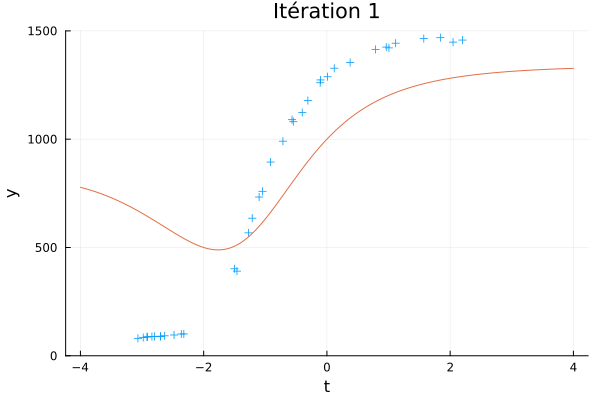

In [12]:
f = (x::Vector, t::Number) -> (x[1] + x[2]*t + x[3]*t^2 + x[4]*t^3) / (1 + x[5]*t + x[6]*t^2 + x[7]*t^3)

entry = range(-4,4,1000)
anim = @animate for i ∈ df[!,:iter]
    scatter(t,y,markershape=:cross, xlabel="t", ylabel="y", legend=:none , ylim = (0,1500))
    x = str_to_array(df[i,:x])
    plot!(entry, (t -> f(x,t)).(entry),title="Itération $i")
end
gif(anim, fps = 2)